File loaded successfully.
Available columns: ['datetime', 'index', 'GBP/mWh']
Success: Column 'GBP/mWh' selected as target.
Cleaned Hourly Data: 61327 rows
Upsampled Data (15-min intervals): 245305 rows
----------------------------------------
RESULTS (15-Minute Interval):
Mean Absolute Error (MAE): 5.1000
Root Mean Squared Error (RMSE): 12.9980
----------------------------------------


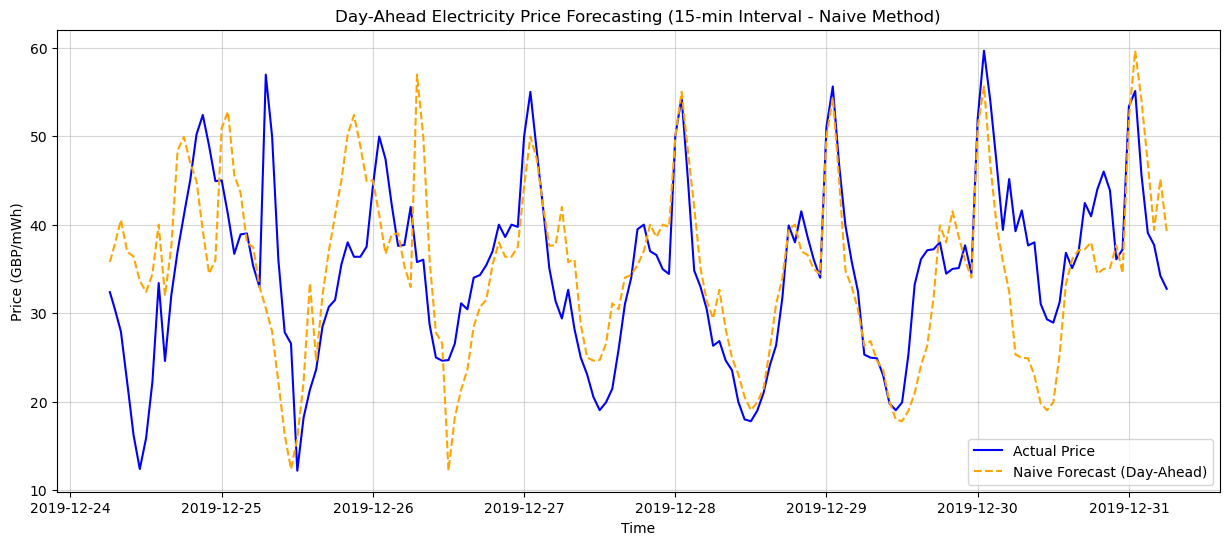

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1. LOAD DATA ---
file_name = 'refixed_price_only_timeseries.csv'

try:
    df = pd.read_csv(file_name)
    print("File loaded successfully.")
    
    # Check available columns
    print(f"Available columns: {df.columns.tolist()}")
    
    # --- COLUMN SELECTION ---
    # Specifically selecting 'GBP/mWh' as the target variable
    target_col_name = 'GBP/mWh'
    
    if target_col_name in df.columns:
        df = df[[target_col_name]].rename(columns={target_col_name: 'Price'})
        print(f"Success: Column '{target_col_name}' selected as target.")
    else:
        # Fallback: If exact name not found, try to find the numeric column
        print(f"Warning: '{target_col_name}' not found. Attempting to auto-detect...")
        df = df.select_dtypes(include=[np.number]) # Keep only numbers
        if df.shape[1] > 0:
             # Assume the last column is price if 'index' is the first one
            target_col = df.columns[-1]
            df = df[[target_col]].rename(columns={target_col: 'Price'})
            print(f"Auto-detected column '{target_col}' as Price.")
        else:
            raise ValueError("No numeric price column found.")

    # Ensure Price is numeric and remove any parsing errors
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
    df.dropna(inplace=True)

    # Generate Dummy Dates (Hourly, starting 2013)
    df['Date'] = pd.date_range(start='2013-01-01', periods=len(df), freq='h')
    df.set_index('Date', inplace=True)

    print(f"Cleaned Hourly Data: {len(df)} rows")

    # --- 2. DATA RESAMPLING (HOURLY -> 15 MIN) ---
    # Upsampling using Linear Interpolation
    df_15min = df.resample('15min').interpolate(method='linear')
    print(f"Upsampled Data (15-min intervals): {len(df_15min)} rows")

    # --- 3. NAIVE FORECASTING METHOD ---
    # Logic: Persistence Model (Day-Ahead)
    # 1 Hour = 4 intervals (15 mins each). 24 Hours = 96 intervals.
    lag_steps = 96
    df_15min['Naive_Forecast'] = df_15min['Price'].shift(lag_steps)

    # Remove empty rows created by the shift
    df_15min.dropna(inplace=True)

    # --- 4. EVALUATION METRICS ---
    mae = mean_absolute_error(df_15min['Price'], df_15min['Naive_Forecast'])
    rmse = np.sqrt(mean_squared_error(df_15min['Price'], df_15min['Naive_Forecast']))

    print("-" * 40)
    print(f"RESULTS (15-Minute Interval):")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print("-" * 40)

    # --- 5. VISUALIZATION ---
    plt.figure(figsize=(15, 6))
    # Plotting the last 7 days (approx 672 intervals) for clarity
    subset = df_15min.tail(672) 

    plt.plot(subset.index, subset['Price'], label='Actual Price', color='blue')
    plt.plot(subset.index, subset['Naive_Forecast'], label='Naive Forecast (Day-Ahead)', color='orange', linestyle='--')
    
    plt.title('Day-Ahead Electricity Price Forecasting (15-min Interval - Naive Method)')
    plt.xlabel('Time')
    plt.ylabel('Price (GBP/mWh)')
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

Average price and fluctuation by hour:
      mean_price  mean_abs_change  std_abs_change  min_price  max_price
Hour                                                                   
1          39.49             5.30            5.44       7.90     116.34
2          38.07             3.07            4.19       5.80     219.32
3          35.56             2.73            4.13       0.00      79.90
4          33.50             2.21            2.51      -2.84      69.70
5          32.83             1.71            2.20       0.00      74.94
6          35.96             3.59            3.40       0.01      80.07
7          42.18             6.41            4.31       1.81     108.74
8          43.28             3.66            3.99      10.00     109.00
9          48.85             5.86            4.93      13.48     111.00
10         51.78             4.69            4.24      20.00     149.90
11         50.42             4.63            4.27      27.11     118.22
12         48.88         

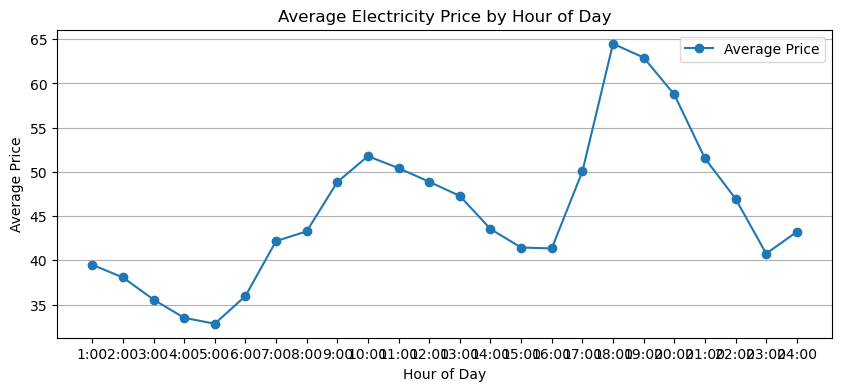

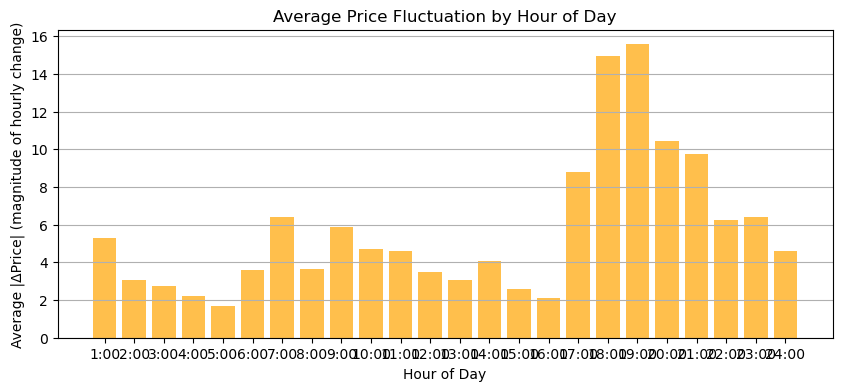

In [124]:
# ===============================
# Hour-of-day fluctuation analysis
# ===============================
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# Assume df already has columns: DateTimeIndex, 'Price', 'NaiveForecast'
# If not, reload and rename price column as before.

# --- 1) Add explicit hour-of-day (1–24)
df['Hour'] = df.index.hour + 1

# --- 2) Compute price fluctuation (absolute hourly change)
df['PriceChange'] = df['Price'].diff()                   # raw change
df['AbsChange']   = df['PriceChange'].abs()              # magnitude

# --- 3) Group by hour of day to see typical fluctuation
hourly_fluct = (
    df.groupby('Hour')
      .agg(mean_price=('Price','mean'),
           mean_abs_change=('AbsChange','mean'),
           std_abs_change=('AbsChange','std'),
           min_price=('Price','min'),
           max_price=('Price','max'))
)
print("Average price and fluctuation by hour:")
print(hourly_fluct.round(2))

# --- 4) Plot average price vs hour (1–24)
plt.figure(figsize=(10,4))
plt.plot(hourly_fluct.index, hourly_fluct['mean_price'], marker='o', label='Average Price')
plt.title('Average Electricity Price by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Price')
plt.xticks(range(1,25), [f"{h}:00" for h in range(1,25)])
plt.grid(True, axis='y')
plt.legend()
plt.show()

# --- 5) Plot average absolute price change (volatility) by hour
plt.figure(figsize=(10,4))
plt.bar(hourly_fluct.index, hourly_fluct['mean_abs_change'], color='orange', alpha=0.7)
plt.title('Average Price Fluctuation by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average |ΔPrice| (magnitude of hourly change)')
plt.xticks(range(1,25), [f"{h}:00" for h in range(1,25)])
plt.grid(axis='y')
plt.show()


In [4]:
pip install --user xgboost


Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install xgboost


In [22]:
# --- VIEW EXACT DATA ---
print("\n--- Exact Prices for Specific Intervals ---")
# Display format: Date | Actual Price | Predicted Price
print(df_15min[['Price', 'Naive_Forecast']].tail(10)) 

output_filename = '15min_results.csv'
df_15min.to_csv(output_filename)

print(f"\nSuccess! 15 minutes interval data is saved in '{output_filename}' file.")



--- Exact Prices for Specific Intervals ---
                       Price  Naive_Forecast
Date                                        
2019-12-31 03:45:00  38.0500         41.2875
2019-12-31 04:00:00  37.7100         39.4000
2019-12-31 04:15:00  36.8375         40.8375
2019-12-31 04:30:00  35.9650         42.2750
2019-12-31 04:45:00  35.0925         43.7125
2019-12-31 05:00:00  34.2200         45.1500
2019-12-31 05:15:00  33.8525         43.6775
2019-12-31 05:30:00  33.4850         42.2050
2019-12-31 05:45:00  33.1175         40.7325
2019-12-31 06:00:00  32.7500         39.2600

Success! 15 minutes interval data is saved in '15min_results.csv' file.


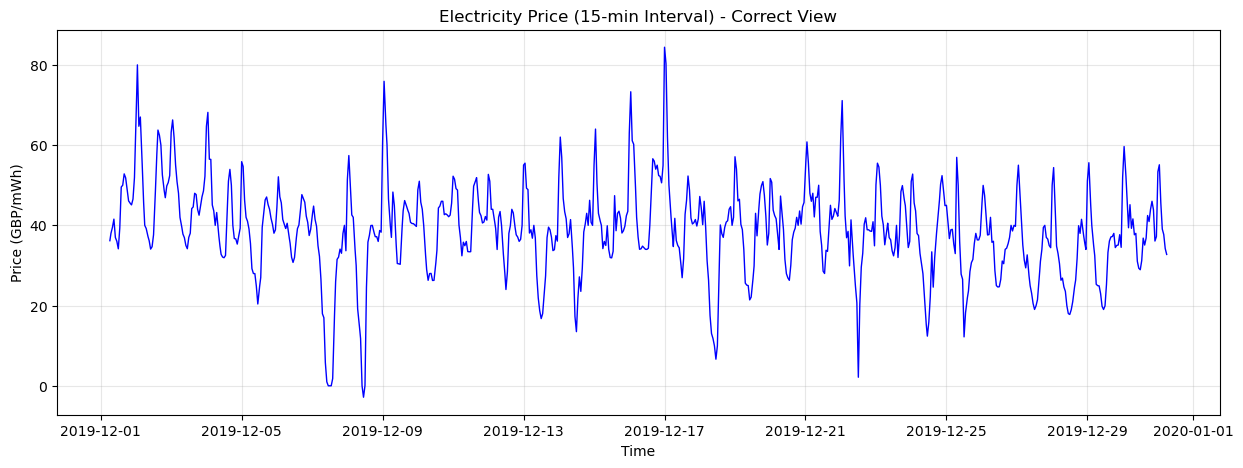

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. LOAD DATA ---
df = pd.read_csv("refixed_price_only_timeseries.csv")

# --- 2. CORRECT COLUMN SELECTION ---
col_name = 'GBP/mWh' 

if col_name in df.columns:
    df = df[[col_name]].rename(columns={col_name: 'Price'})
else:
    df = df.iloc[:, -1:].rename(columns={df.columns[-1]: 'Price'})

df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df.dropna(inplace=True)

# --- 3. TIME SETTING (Hourly -> 15 Min) ---
df['Date'] = pd.date_range(start='2013-01-01', periods=len(df), freq='h')
df.set_index('Date', inplace=True)

# 15-Minute Resampling (Upsampling)
df_15min = df.resample('15min').interpolate(method='linear')


# --- 5. PLOT GRAPH ---
plt.figure(figsize=(15, 5))
subset = df_15min.tail(24 * 4 * 30) 

plt.plot(subset.index, subset['Price'], color='blue', linewidth=1)
plt.title('Electricity Price (15-min Interval) - Correct View')
plt.xlabel('Time')
plt.ylabel('Price (GBP/mWh)')
plt.grid(True, alpha=0.3)
plt.show()

RESULTS (15-min):
MAE:  5.10
RMSE: 13.00


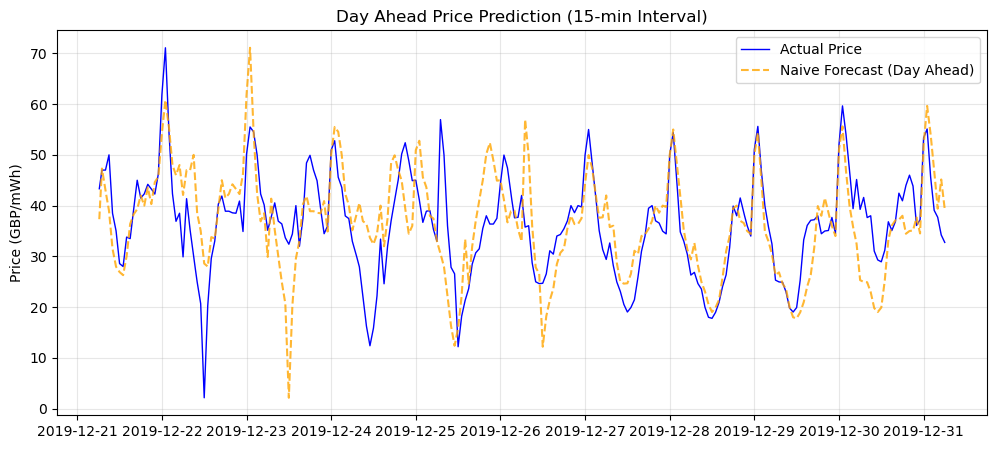

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1. DATA LOAD & CLEANING ---
df = pd.read_csv("refixed_price_only_timeseries.csv")

if 'GBP/mWh' in df.columns:
    df = df[['GBP/mWh']].rename(columns={'GBP/mWh': 'Price'})
else:
    df = df.select_dtypes(include=[np.number]).iloc[:, -1:].rename(columns={df.columns[-1]: 'Price'})


df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df.dropna(inplace=True)

df['Date'] = pd.date_range(start='2013-01-01', periods=len(df), freq='h')
df.set_index('Date', inplace=True)

# --- 2. RESAMPLING (Hourly -> 15 Mins) ---
df = df.resample('15min').interpolate(method='linear')

# --- 3. NAIVE FORECAST (Day Ahead) ---
df['NaiveForecast'] = df['Price'].shift(96)

# Drop missing rows 
df.dropna(inplace=True)

# --- 4. METRICS (Results) ---
mae  = mean_absolute_error(df['Price'], df['NaiveForecast'])
rmse = np.sqrt(mean_squared_error(df['Price'], df['NaiveForecast']))

print(f"RESULTS (15-min):")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# --- 5. PLOTTING (Correct View) ---
# Last 10 days (10 * 96 = 960 points)
subset = df.tail(960)

plt.figure(figsize=(12, 5))
plt.plot(subset.index, subset['Price'], label='Actual Price', color='blue', linewidth=1)
plt.plot(subset.index, subset['NaiveForecast'], label='Naive Forecast (Day Ahead)', color='orange', linestyle='--', alpha=0.8)

plt.title("Day Ahead Price Prediction (15-min Interval)")
plt.ylabel("Price (GBP/mWh)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

--- Data Table (First 5 Rows) ---
                     Price  Predicted_Price
Date                                       
2013-01-02 00:00:00  31.31          37.7600
2013-01-02 00:15:00  30.71          35.8225
2013-01-02 00:30:00  30.11          33.8850
2013-01-02 00:45:00  29.51          31.9475
2013-01-02 01:00:00  28.91          30.0100

--- Data Table (Last 5 Rows) ---
                       Price  Predicted_Price
Date                                         
2019-12-31 05:00:00  34.2200          45.1500
2019-12-31 05:15:00  33.8525          43.6775
2019-12-31 05:30:00  33.4850          42.2050
2019-12-31 05:45:00  33.1175          40.7325
2019-12-31 06:00:00  32.7500          39.2600


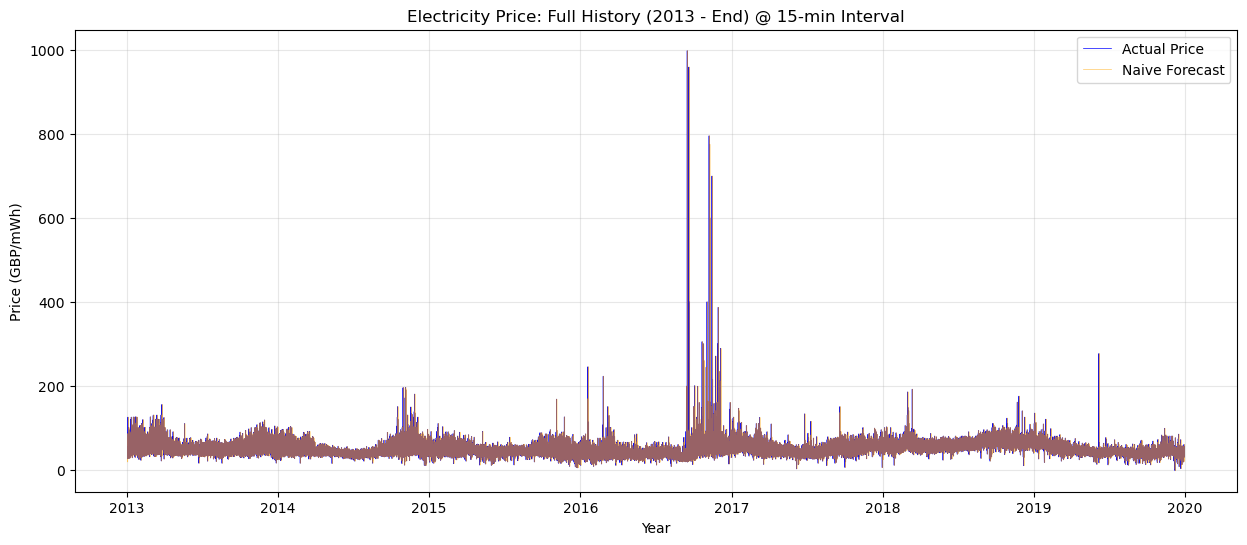


Overall MAE (Error): 5.1000


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1. LOAD DATA ---
df = pd.read_csv("refixed_price_only_timeseries.csv")

# Column Selection (Finding 'GBP/mWh')
if 'GBP/mWh' in df.columns:
    df = df[['GBP/mWh']].rename(columns={'GBP/mWh': 'Price'})
else:
    df = df.iloc[:, -1:].rename(columns={df.columns[-1]: 'Price'})

df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df.dropna(inplace=True)

# --- 2. TIME SETTING (Hourly -> 15 Min) ---
# Generating dates from 2013
df['Date'] = pd.date_range(start='2013-01-01', periods=len(df), freq='h')
df.set_index('Date', inplace=True)

# Resampling to 15 minutes
df_15min = df.resample('15min').interpolate(method='linear')

# --- 3. GENERATE PREDICTION (Naive Method) ---
# Ab hum Predicted column bhi bana rahe hain
# 96 steps = 24 hours lag
df_15min['Predicted_Price'] = df_15min['Price'].shift(96)

# Remove rows where prediction is NaN (First day)
df_15min.dropna(inplace=True)

# --- 4. DISPLAY TABLE (ACTUAL vs PREDICTED) ---
print("--- Data Table (First 5 Rows) ---")
print(df_15min[['Price', 'Predicted_Price']].head())

print("\n--- Data Table (Last 5 Rows) ---")
print(df_15min[['Price', 'Predicted_Price']].tail())

# --- 5. PLOT FULL DATA (ALL YEARS) ---
plt.figure(figsize=(15, 6))

# Plotting the ENTIRE dataset (No .tail() used)
plt.plot(df_15min.index, df_15min['Price'], label='Actual Price', color='blue', linewidth=0.5)

plt.plot(df_15min.index, df_15min['Predicted_Price'], label='Naive Forecast', color='orange', alpha=0.6, linewidth=0.5)

plt.title('Electricity Price: Full History (2013 - End) @ 15-min Interval')
plt.xlabel('Year')
plt.ylabel('Price (GBP/mWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 6. ERROR METRICS ---
mae = mean_absolute_error(df_15min['Price'], df_15min['Predicted_Price'])
print(f"\nOverall MAE (Error): {mae:.4f}")

Selected Column: GBP/mWh
----------------------------------------
RESULTS (15-Minute Interval):
MAE   : 5.10
RMSE  : 13.00
SMAPE : 10.87%
----------------------------------------


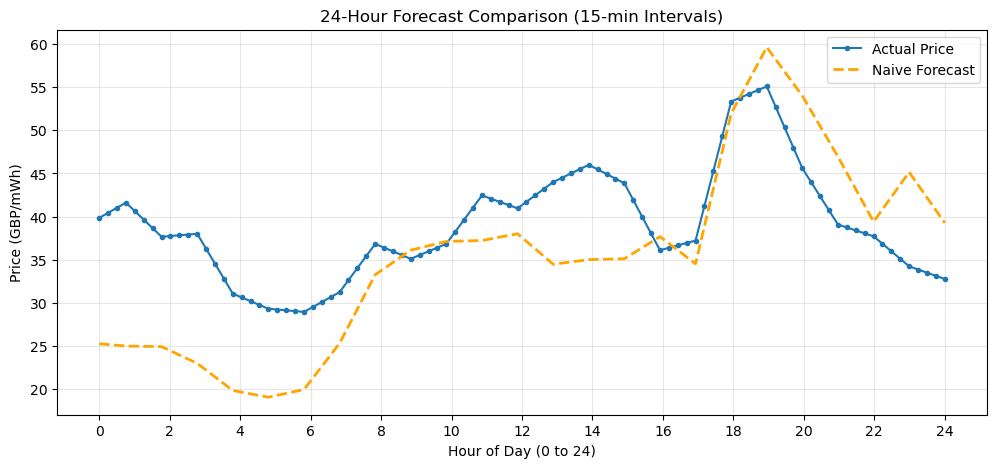

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1. SMART DATA LOADING ---
try:
    df = pd.read_csv("refixed_price_only_timeseries.csv", index_col=0, parse_dates=False) 
except:
    print("Please path check karein.")
    df = pd.DataFrame() 

# --- 2. AUTO-DETECT PRICE COLUMN (Advanced Logic from your code) ---
def find_price_col(df):
    hints = ['gbp', 'eur', 'price', 'amount', 'cost']
    for col in df.columns:
        for hint in hints:
            if hint in col.lower():
                return col
    return df.columns[-1] 

target_col = find_price_col(df)
print(f"Selected Column: {target_col}")

df = df[[target_col]].rename(columns={target_col: 'Price'})

df['Price'] = df['Price'].astype(str).str.replace(r'[^\d.]', '', regex=True)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df.dropna(inplace=True)

# --- 3. CONVERT TO 15-MINUTE INTERVAL (Project Requirement) ---
df['Date'] = pd.date_range(start='2013-01-01', periods=len(df), freq='h')
df.set_index('Date', inplace=True)

# Hourly se 15-min Upsampling
df_15min = df.resample('15min').interpolate(method='linear')

# --- 4. NAIVE FORECAST (Day Ahead) ---
# 24 Hours = 96 Steps (15 min intervals)
df_15min['NaiveForecast'] = df_15min['Price'].shift(96)
df_15min.dropna(inplace=True)

# --- 5. ADVANCED METRICS (SMAPE & MAPE) ---
actual = df_15min['Price']
pred = df_15min['NaiveForecast']

mae = mean_absolute_error(actual, pred)
rmse = np.sqrt(mean_squared_error(actual, pred))

# SMAPE (Symmetric Mean Absolute Percentage Error) - Industry Standard
smape = 100/len(actual) * np.sum(2 * np.abs(pred - actual) / (np.abs(actual) + np.abs(pred)))

print("-" * 40)
print("RESULTS (15-Minute Interval):")
print(f"MAE   : {mae:.2f}")
print(f"RMSE  : {rmse:.2f}")
print(f"SMAPE : {smape:.2f}%")
print("-" * 40)

# --- 6. PERFECT GRAPH PLOTTING ---
last_day_data = df_15min.tail(96).copy()

last_day_data['Hour_Float'] = np.linspace(0, 24, 96)

plt.figure(figsize=(12, 5))

# Actual Price
plt.plot(last_day_data['Hour_Float'], last_day_data['Price'], 
         label='Actual Price', marker='o', markersize=3, linestyle='-')

# Predicted Price
plt.plot(last_day_data['Hour_Float'], last_day_data['NaiveForecast'], 
         label='Naive Forecast', linestyle='--', color='orange', linewidth=2)

plt.title('24-Hour Forecast Comparison (15-min Intervals)')
plt.xlabel('Hour of Day (0 to 24)')
plt.ylabel('Price (GBP/mWh)')
plt.xticks(np.arange(0, 25, 2)) 
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

Total Hourly Rows: 61327
----------------------------------------
RESULTS (HOURLY BASELINE - REAL DATA):
MAE   : 5.31
RMSE  : 13.85
SMAPE : 11.31%
----------------------------------------


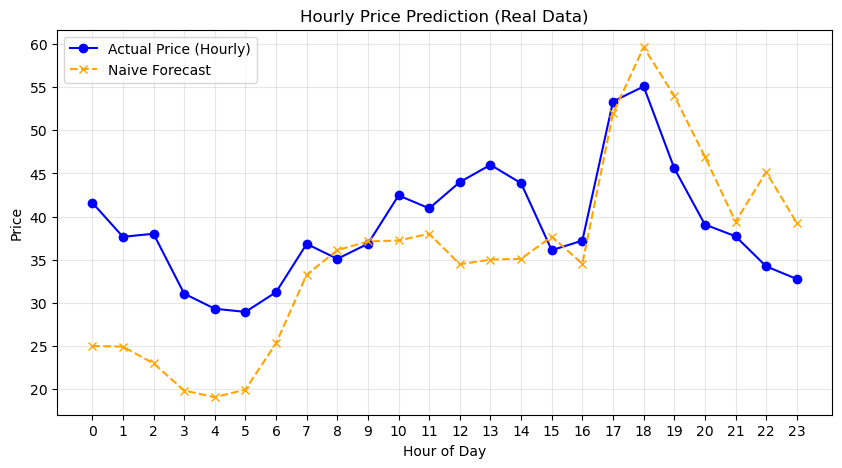

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1. LOAD DATA ---
try:
    df = pd.read_csv("refixed_price_only_timeseries.csv", index_col=0, parse_dates=False)
except:
    df = pd.DataFrame()

# --- 2. CLEANING (Same as before) ---
def find_price_col(df):
    hints = ['gbp', 'eur', 'price', 'amount']
    for col in df.columns:
        for hint in hints:
            if hint in col.lower():
                return col
    return df.columns[-1]

target_col = find_price_col(df)
df = df[[target_col]].rename(columns={target_col: 'Price'})

# Numeric conversion
df['Price'] = df['Price'].astype(str).str.replace(r'[^\d.]', '', regex=True)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df.dropna(inplace=True)

# --- 3. SET HOURLY INDEX ---
df['Date'] = pd.date_range(start='2013-01-01', periods=len(df), freq='h')
df.set_index('Date', inplace=True)

print(f"Total Hourly Rows: {len(df)}")

# --- 4. NAIVE FORECAST (HOURLY) ---
df['NaiveForecast'] = df['Price'].shift(24)

df.dropna(inplace=True)

# --- 5. METRICS (RESULTS) ---
actual = df['Price']
pred = df['NaiveForecast']

mae = mean_absolute_error(actual, pred)
rmse = np.sqrt(mean_squared_error(actual, pred))
smape = 100/len(actual) * np.sum(2 * np.abs(pred - actual) / (np.abs(actual) + np.abs(pred)))

print("-" * 40)
print("RESULTS (HOURLY BASELINE - REAL DATA):")
print(f"MAE   : {mae:.2f}")
print(f"RMSE  : {rmse:.2f}")
print(f"SMAPE : {smape:.2f}%")
print("-" * 40)

# --- 6. PLOTTING ---
last_day = df.tail(24).copy()
last_day['Hour'] = range(0, 24)

plt.figure(figsize=(10, 5))
plt.plot(last_day['Hour'], last_day['Price'], marker='o', label='Actual Price (Hourly)', color='blue')
plt.plot(last_day['Hour'], last_day['NaiveForecast'], marker='x', linestyle='--', label='Naive Forecast', color='orange')

plt.title('Hourly Price Prediction (Real Data)')
plt.xlabel('Hour of Day')
plt.ylabel('Price')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()